## Project topic:

In this project we will build a model to predict the electrical energy output of a Combined Cycle Power Plant, which uses a combination of gas turbines, steam turbines, and heat recovery steam generators to generate power.  We have a set of 9568 hourly average ambient environmental readings from sensors at the power plant which we will use in our model.

The columns in the data consist of hourly average ambient variables:
- Temperature (T) in the range 1.81°C to 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
- Net hourly electrical energy output (PE) 420.26-495.76 MW (Target we are trying to predict)

The dataset may be downloaded as a csv file.  Note that Safari users may have to navigate to File -> Save As and select the option "Save as source" to download the file.  Once you have downloaded the data, please review the Project Modeling Options reading and select a method of working with the data to build your model: 1) using Excel, 2) using Python, or 3) using Google AutoML.

## Data source:

Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615.

Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)

## Guidelines for the project:

To complete the project, you must complete each of the below steps in the modeling process.  

For the problem described in the Project Topic section above, determine what type of machine learning approach is needed and select an appropriate output metric to evaluate performance in accomplishing the task.

Determine which possible features we may want to use in the model, and identify the different algorithms we might consider.

Split your data to create a test set to evaluate the performance of your final model.  Then, using your training set, determine a validation strategy for comparing different models - a fixed validation set or cross-validation.  Depending on whether you are using Excel, Python or AutoML for your model building, you may need to manually split your data to create the test set and validation set / cross validation folds.

Use your validation approach to compare at least two different models (which may be either 1) different algorithms, 2) the same algorithm with different combinations of features, or 3) the same algorithm and features with different values for hyperparameters).  From among the models you compare, select the model with the best performance on your validation set as your final model.

Evaluate the performance of your final model using the output metric you defined earlier.  

Once you have completed all steps, create and record a brief (5 minutes maximum) presentation video describing your approach to each step.  Your video must include a quick demo or screenshot of the final model you have created.  In your video, be sure to clearly address the 4 elements on which your presentation will be evaluated.

## How to submit:

After you complete the above steps and record your project video, upload your video to a public cloud or video sharing platform such as YouTube.  Submit the link to your recorded video as your project submission (you do not need to submit any other files besides the video).

In [44]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

In [4]:
#load in the data
df = pd.read_csv('CCPP_data.csv')
df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [5]:
#rename the columns and then describe
cols = ['Temperature', 'Exhaust Vacuum', 'Ambient Pressure', 'Relative Humidity', 'Net hourly electrical energy output']
df.columns = cols

df.describe()

,Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net hourly electrical energy output
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


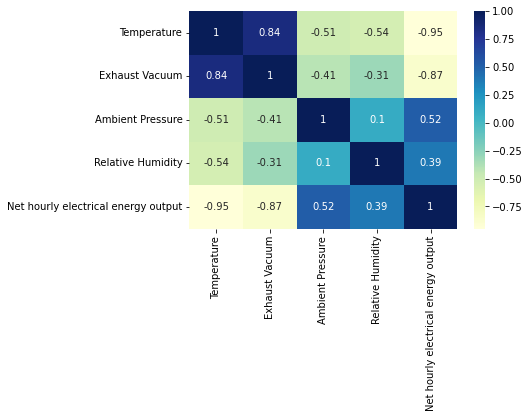

In [7]:
#check correlations between variables

dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

Looks like our target variable is very strongly correlated with exhaust vacuum and temperature. Much more so than Ambient Pressure or Relative Humidity. It also looks like exhaust vacuum and temperature are highly correlated with each other which could create an issue (multicollinearity).

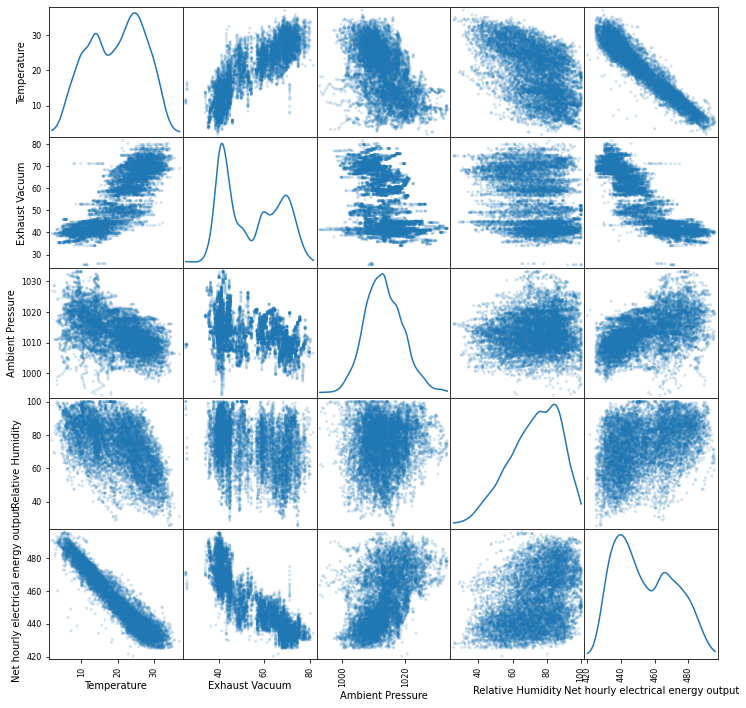

In [17]:
#let's look at our data visually
scatter_matrix(df, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

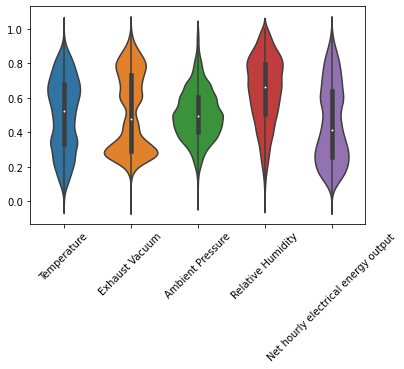

In [29]:
#let's plot distributions with respect to the target variables after normalizing the data
scaler = MinMaxScaler()

df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


ax = sns.violinplot(data= df_norm)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

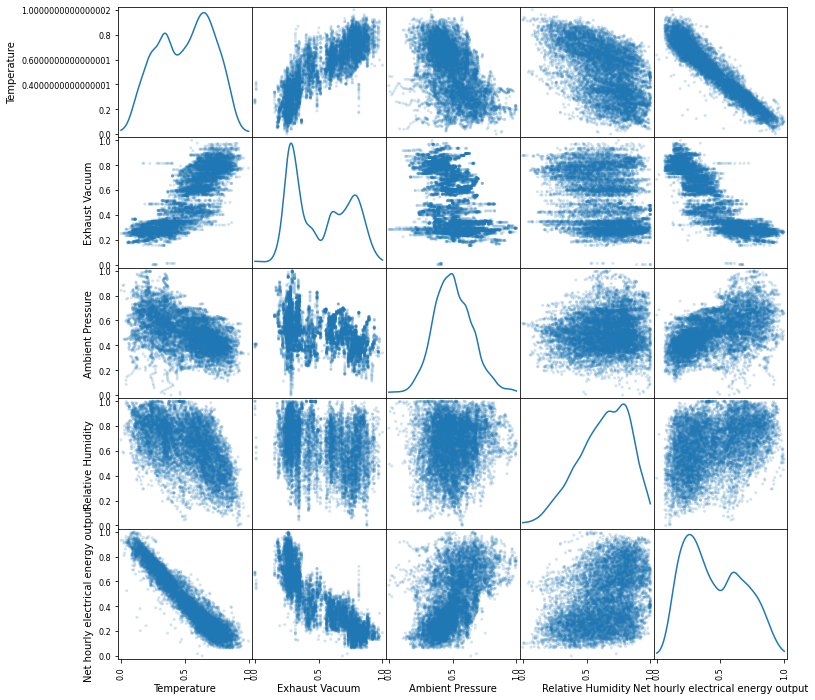

In [36]:
scatter_matrix(df_norm, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.show()

I'm glad we visualized the data. While Temperature and Exhaust Vacuum appear to be highly correlated when using Pearson's r, they seem to have different non-normal distributions. To handle the issue of scale, going forward we'll use normalized data for our feature set.

Let's now get the data ready and train our models. Because this is a regression task, we'll use a linear regression model, a random forest regressor, and the base XGBoost Regressor.


In [35]:
#split the data into train and test sets

X = pd.DataFrame(scaler.fit_transform(df.iloc[:,:-1]), columns=df.iloc[:,:-1].columns)
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)


In [59]:
#Now that we've split the data, let's create our models
linear = LinearRegression()
rf = RandomForestRegressor(random_state = 42, verbose = True)

In [78]:
#let's fit our linear regression model first.
linear.fit(X_train, y_train)

LinearRegression()

In [79]:
#let's predict values and then evaluate
y_preds = linear.predict(X_test)

To evaluate performance, let's use mean % error to see how far we're off in relation to the scale of our data. Let's also check MSE.

In [80]:
print("Mean Squared Error: " , metrics.mean_squared_error(y_test, y_preds) , " Mean Absolute Percentage Error: ", metrics.mean_absolute_percentage_error(y_test, y_preds))

#This is interesting. Our average error is less than 1%

Mean Squared Error:  20.581925958913825  Mean Absolute Percentage Error:  0.007910777984882926


In [83]:
#to view the coefficients and intercept of our regression algorithm
print("Coefficients: ", linear.coef_,", Intercept: ", linear.intercept_)

Coefficients:  [-70.45659436 -12.86610017   2.31258839 -11.83922497] , Intercept:  503.02537804219503


We're going to use tune the hyperparameters of the Random Forest model using try to beat the performance of our linear regression model.

In [56]:
#let's create the parameter grid first

random_grid = {
    'n_estimators': range(100,1000,10),
    'max_depth': range(10,100,5),
    'min_samples_split': range(2,10),
    'bootstrap': [True,False]
    
}

In [60]:
#Randomized Search with CV
rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 5, 
                             verbose = True, n_jobs = -1, random_state = 42)

In [61]:
rf_rand.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed:   16.4s finished


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(random_state=42,
                                                   verbose=True),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': range(10, 100, 5),
                                        'min_samples_split': range(2, 10),
                                        'n_estimators': range(100, 1000, 10)},
                   random_state=42, verbose=True)

In [63]:
#find the best parameters
rf_rand.best_params_

{'n_estimators': 900,
 'min_samples_split': 5,
 'max_depth': 45,
 'bootstrap': True}

In [69]:
#train new Random Forest model using the params from best params
rf_new = RandomForestRegressor(n_estimators = 900, min_samples_split = 5, max_depth = 45, 
                               verbose = True, random_state = 42, n_jobs = -1)

In [70]:
#fit the model
rf_new.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 788 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:    4.8s finished


RandomForestRegressor(max_depth=45, min_samples_split=5, n_estimators=900,
                      n_jobs=-1, random_state=42, verbose=True)

In [73]:
#predict new data
rf_y_preds = rf_new.predict(X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:    0.2s
[Parallel(n_jobs=6)]: Done 900 out of 900 | elapsed:    0.2s finished


In [74]:
#evaluate performance
print("Mean Squared Error: " , metrics.mean_squared_error(y_test, rf_y_preds) , " Mean Absolute Percentage Error: ", metrics.mean_absolute_percentage_error(y_test, rf_y_preds))
#Looks like we have a performance improvement compared to our earlier linear model. Average % error is now close to 0.5%

Mean Squared Error:  11.062320421471364  Mean Absolute Percentage Error:  0.005188213355147902


## Conclusion

We were successfully able to train a RandomForestRegressor model to outperform our linear regression model. For both models the absolute error is quite small when scaled to the data.